# Analytical solutions for groundwater flow through aquifer folds and faults
### Mark Bakker and Erik Anderson

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy. optimize import fsolve
#
plt.rcParams['figure.figsize'] = [3.6, 2.4] # default figure size
plt.rcParams['font.size'] = 8 # default font size

### Parameters used in most models

In [2]:
# parameters
L = 1 # length of reference plane
H = 1 # thickness of aquifer (equal on both sides)
Q = 1 # total flow through system

### Functions for $z(\zeta)$

In [3]:
def func(zeta, zetad, xc, A, L, B):
    # function F
    rv = A / np.pi * np.log(
    (np.exp(np.pi * zeta / B) - np.exp(np.pi * (xc + zetad) / B)) /
    (np.exp(np.pi * zeta / B) - np.exp(np.pi * (xc - zetad) / B)))
    rv -= A * zetad.real / B
    return rv  

def funcp(zeta, zetad, xc, A, L, B):
    # function Fprime
    rv = A / B * np.exp(np.pi * zeta / B) * (
    1 / (np.exp(np.pi * zeta / B) - np.exp(np.pi * (xc + zetad) / B)) -
    1 / (np.exp(np.pi * zeta / B) - np.exp(np.pi * (xc - zetad) / B)))
    return rv       
    
def funcF(zeta, zetad, A, L, B, N=2):
    # function F with N images
    rv = 0
    for n in np.arange(-N, N + 1):
        xc = 2 * L * n
        rv += func(zeta, zetad, xc, A, L, B)
    rv += A * zetad.real * zeta / (B * L)
    return rv

def funcFp(zeta, zetad, A, L, B, N=2):
    # function Fprime with N images
    rv = 0
    for n in np.arange(-N, N + 1):
        xc = 2 * L * n
        rv += funcp(zeta, zetad, xc, A, L, B)
    rv += A * zetad.real / (B * L)
    return rv

def funcz(zeta, delta, H, L, B, N, linearterm=0):
    # z(zeta) with zeta_1 = delta and zeta_4 = L - delta + iB
    f = funcF(zeta, zetad=delta + 0j, A=-H, L=L, B=B, N=N) + \
        funcF(zeta, zetad=L - delta + B * 1j, A=H, L=L, B=B, N=N) + \
        A * 1j
        #2 * (N + 1) * A * 1j
    f += linearterm * zeta
    return f

def funczp(zeta, delta, H, L, B, N, linearterm=0):
    # zprime(zeta) with zeta_1 = delta and zeta_4 = L - delta + iB
    f = funcFp(zeta, zetad=delta + 0j, A=-H, L=L, B=B, N=N) + \
        funcFp(zeta, zetad=L - delta + B * 1j, A=H, L=L, B=B, N=N)
    f += linearterm
    return f

def funczpreal(B, delta, H, L, N, linearterm=0):
    # real part of zprime(zeta) with zeta_1 = delta and zeta_4 = L - delta + iB
    return funczp(B * 1j, delta, H, L, B, N, linearterm).real

def compzboundary(L, B, H, delta, N=2, npoints=100, eps=0.01, linearterm=0, eps2=1e-6):
    # computes boundary in physical plane with zeta_1 = delta and zeta_4 = L - delta + iB
    xi1 = np.hstack((np.linspace(delta + eps, L - eps2, npoints), (L - eps2) * np.ones(npoints), 
                     np.linspace(L - eps2, L - delta + eps, npoints)))
    eta1 = np.hstack((eps2 * np.ones(npoints), np.linspace(eps2, B - eps2, npoints), (B - eps2) * np.ones(npoints)))
    zeta1 = xi1 + eta1 * 1j
    z1 = funcz(zeta1, delta, H, L, B, N) + linearterm * zeta1
    xi2 = np.hstack((np.linspace(L - delta - eps, eps2, npoints), eps2 * np.ones(npoints), 
                     np.linspace(eps2, delta - eps, npoints)))
    eta2 = np.hstack((B * np.ones(100) - eps2, np.linspace(B - eps2, eps2, npoints), eps2 * np.ones(npoints)))
    zeta2 = xi2 + eta2 * 1j
    z2 = funcz(zeta2, delta, H, L, B, N) + linearterm * zeta2
    return z1, z2

### Functions for $\Omega(\zeta)$

In [4]:
def funcG(zeta, delta, A, L, B, xc):
    # main term in omega  with zeta_1 = delta and zeta_4 = L - delta + iB
    rv = A / np.pi * np.log(
        ((np.exp(np.pi * zeta / B) - np.exp(np.pi * (xc + delta) / B)) * 
         (np.exp(np.pi * zeta / B) - np.exp(np.pi * (xc - delta) / B))) /
        ((np.exp(np.pi * zeta / B) - np.exp(np.pi * (xc + (L - delta + B * 1j)) / B)) * 
         (np.exp(np.pi * zeta / B) - np.exp(np.pi * (xc - (L - delta + B * 1j)) / B))))
    return rv   

def funcOmega(zeta, delta, Q, L, B, N):
    # omega(zeta) with zeta_1 = delta and zeta_4 = L - delta + iB
    rv = 0
    for n in np.arange(-N, N + 1):
        xc = 2 * L * n
        rv += funcG(zeta, delta, Q, L, B, xc)
    return rv

### Solution for flow through a fault

In [5]:
L = 1
H = 1
A = H
Q = 1
delta = 0.25
N = 2

In [6]:
B = fsolve(funczpreal, x0=1, args=(delta, H, L, N))[0]
print('value of B and z(Bi)', B, funcz(0 + (B - 1e-6) * 1j, delta, A, L, B, N))
xi, eta = np.meshgrid(np.linspace(1e-6, L - 1e-6, 400), np.linspace(1e-6, B - 1e-6, 400))
zeta = xi + eta * 1j
z = funcz(zeta, delta, A, L, B, N)
om = funcOmega(zeta, delta, Q, L, B, N)
z1, z2 = compzboundary(L, B, H, delta, N, eps=1e-3)

value of B and z(Bi) 0.6396307855708526 (-1.9984014443252818e-15+0.5000000000000007j)


(-0.1, 1.6)

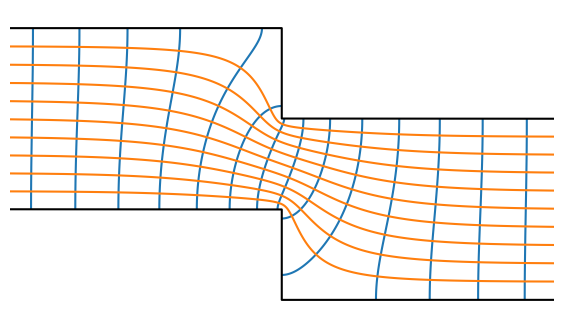

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(aspect=1)
cs = plt.contour(z.real, z.imag, om.real, 20, colors='C0', linestyles='-')
plt.contour(z.real, z.imag, om.imag, 10, colors='C1', linestyles='-')
plt.plot(z1.real, z1.imag, 'k')
plt.plot(z2.real, z2.imag, 'k')
plt.axis('off')
plt.xlim(-1.5, 1.5)
plt.ylim(-0.1, 1.6)
#plt.savefig('flownetpap1.eps', bbox_inches='tight')

#### Solution for three values of B

/var/folders/ky/8r_kg9w91ld3b898xn53q9wm0000gn/T/ipykernel_38428/708203554.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


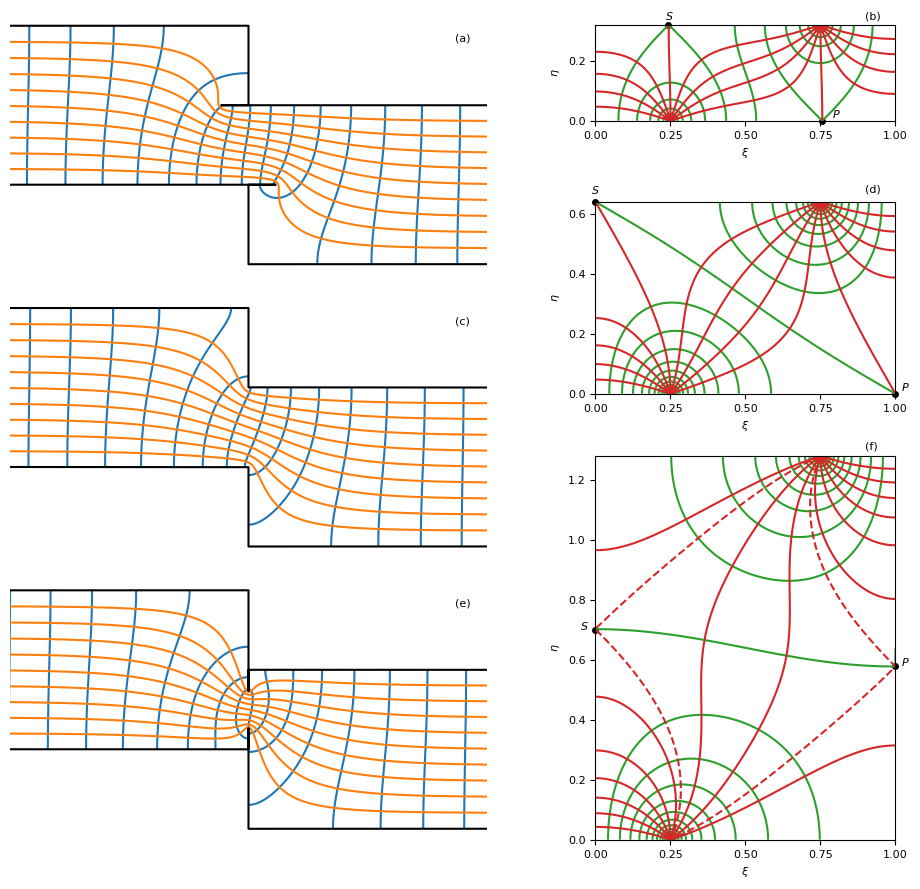

In [8]:
from matplotlib import gridspec
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(7, 2)
Bopt = fsolve(funczpreal, x0=10, args=(delta, H, L, N))[0]
ngrid = 400
for ifig, B in enumerate([0.5 * Bopt, Bopt, 2 * Bopt]):
    xi, eta = np.meshgrid(np.linspace(1e-6, L-1e-6, ngrid), np.linspace(1e-6, B-1e-6, ngrid))
    zeta = xi + eta * 1j
    z = funcz(zeta, delta, A, L, B, N=2)
    om = funcOmega(zeta, delta, Q, L, B, N=2)
    z1, z2 = compzboundary(L, B, H, delta, N=2, eps=1e-3)
    plt.subplot(gs[2 * ifig: 2 * ifig + 2, 0], aspect=1)
    #plt.subplot(gs[2 * ifig], aspect=1)
    #plt.set_aspect('equal')
    plt.contour(z.real, z.imag, om.real, 20, colors='C0', linestyles='-')
    plt.contour(z.real, z.imag, om.imag, np.arange(0, Q, Q / 10), colors='C1', linestyles='-')
    plt.plot(z1.real, z1.imag, 'k')
    plt.plot(z2.real, z2.imag, 'k')
    plt.axis('off')
    plt.xlim(-1.5, 1.5)
    plt.ylim(-0.1, 1.6)
    if ifig == 0:
        plt.text(1.3, 1.4, '(a)')
        plt.axes([.6, .85, .3, .15])
        plt.axis('scaled')
        plt.text(0.9, 0.34, '(b)')
        plt.plot(0.243, B, 'ko', markersize=4, clip_on=False)
        plt.plot(0.756, 0, 'ko', markersize=4, clip_on=False)
        plt.text(0.245, 0.33, '$S$', ha='center', va='bottom')
        plt.text(0.79, 0.01, '$P$')
        #plt.subplot(gs[0, 1], aspect=1)
    elif ifig == 1:
        plt.text(1.3, 1.4, '(c)')
        plt.axes([.6, .55, .3, .3])
        plt.axis('scaled')
        plt.text(0.9, 0.67, '(d)')
        plt.plot(0, B, 'ko', markersize=4, clip_on=False)
        plt.plot(1, 0, 'ko', markersize=4, clip_on=False)
        plt.text(0, B + 0.02, '$S$', ha='center', va='bottom')
        plt.text(1.02, 0.01, '$P$')
        #plt.subplot(gs[1:3, 1], aspect=1)
    elif ifig == 2:
        plt.text(1.3, 1.4, '(e)')
        plt.axes([.6, .15, .3, .4])
        plt.axis('scaled')
        plt.text(0.9, 1.3, '(f)')
        plt.plot(0, 0.7, 'ko', markersize=4, clip_on=False)
        plt.plot(1, 0.58, 'ko', markersize=4, clip_on=False)
        plt.text(-0.05, 0.7, '$S$')
        plt.text(1.02, 0.58, '$P$')
        #plt.subplot(gs[3:6, 1], aspect=1)
    if ifig == 0:
        #plt.contour(zeta.real, zeta.imag, z.real, (-2 - 0.17037, 2 - 0.17037, 21), colors='C2', linestyles='-')
        delpot = 0.17037
        plt.contour(zeta.real, zeta.imag, z.real, np.arange(-10 * delpot, 10 * delpot, delpot), colors='C2', linestyles='-')
    else:
        plt.contour(zeta.real, zeta.imag, z.real, np.arange(-2, 2, 0.1), colors='C2', linestyles='-')
    plt.contour(zeta.real, zeta.imag, z.imag, np.linspace(0, 2, 21), colors='C3', linestyles='-')
    if ifig == 2:
        plt.contour(zeta.real, zeta.imag, z.imag, [0.6329, 1 - 0.1329], colors='C3', linestyles='--')
    plt.xlim(0, 1)
    plt.ylim(0, B)
    plt.xticks(np.arange(0, 1.1, 0.25))
    plt.yticks(np.arange(0, B + 0.01, 0.2))
    plt.xlabel('$\\xi$')
    plt.ylabel('$\eta$')
    #axs[ifig, 1].set_aspect('equal')
plt.tight_layout()
#plt.savefig('variableBfigs.eps', bbox_inches='tight')

### Solution for flow through a fold

B:  1.6838002576483482
corner:  (-1.2212453270876722e-15+1.1735201030593383j)
B:  0.4469204471104696
corner:  (3.774758283725532e-15+0.5212318211558121j)


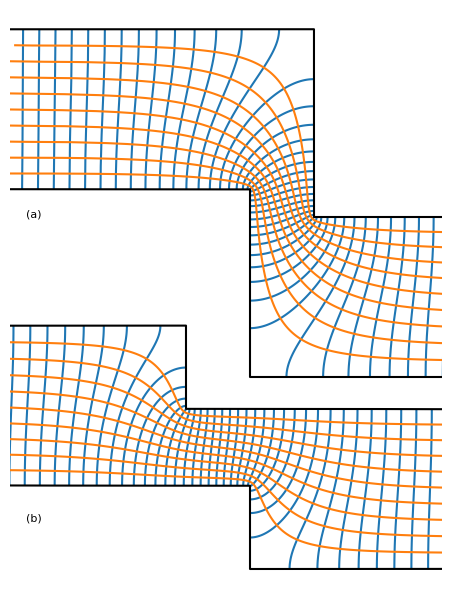

In [9]:
linearterm = 0.4
delta = 0.25
B = fsolve(funczpreal, x0=1, args=(delta, H, L, N, linearterm))[0]
print('B: ', B)
print('corner: ', funcz(B * 1j, delta, A, L, B, N=2, linearterm=linearterm))
xi, eta = np.meshgrid(np.linspace(1e-6, L-1e-6, 400), np.linspace(1e-6, B-1e-6, 400))
zeta = xi + eta * 1j
za = funcz(zeta, delta, A, L, B, N=2, linearterm=linearterm)
oma = funcOmega(zeta, delta, Q, L, B, N=2)
z1a, z2a = compzboundary(L, B, H, delta, N=2, eps=1e-3, linearterm=linearterm)
#
plt.figure(figsize=(10, 6))
plt.subplot(aspect=1)
offset = 1.2
cs = plt.contour(za.real, za.imag + offset, oma.real, np.arange(-3, 3, 0.1), colors='C0', linestyles='-')
plt.contour(za.real, za.imag + offset, oma.imag, np.arange(0, 2, 0.1), colors='C1', linestyles='-')
plt.plot(z1a.real, z1a.imag + offset, 'k')
plt.plot(z2a.real, z2a.imag + offset, 'k')
#plt.axis('off')
plt.xlim(-1.5, 1.2)
plt.ylim(-0.1, 2.6)
plt.text(-1.4, 2.2, '(a)')
plt.tight_layout()
#plt.savefig('flownetpap_move.eps', bbox_inches='tight')
#plt.grid()
#
linearterm = -0.4
delta = 0.15
B = fsolve(funczpreal, x0=1, args=(delta, H, L, N, linearterm))[0]
print('B: ', B)
print('corner: ', funcz(B * 1j, delta, A, L, B, N=2, linearterm=linearterm))
xi, eta = np.meshgrid(np.linspace(1e-6, L-1e-6, 400), np.linspace(1e-6, B-1e-5, 400))
zeta = xi + eta * 1j
z = funcz(zeta, delta, A, L, B, N=2, linearterm=linearterm)
om = funcOmega(zeta, delta, Q, L, B, N=2)
z1, z2 = compzboundary(L, B, H, delta, N=2, eps=1e-3, linearterm=linearterm, eps2=1e-5)
#
cs = plt.contour(z.real, z.imag, om.real, np.arange(-4, 4, 0.1), colors='C0', linestyles='-')
plt.contour(z.real, z.imag, om.imag, np.arange(0, 2, 0.1), colors='C1', linestyles='-')
plt.plot(z1.real, z1.imag, 'k')
plt.plot(z2.real, z2.imag, 'k')
plt.axis('off')
plt.xlim(-1.5, 1.2)
plt.ylim(-0.1, 3.5)
plt.text(-1.4, 0.3, '(b)')
plt.tight_layout()
#plt.savefig('flownetpap_move.eps', bbox_inches='tight')

### Solution for non-symmetric locations of $\zeta_1$ and $\zeta_4$

In [69]:
def funcz_arbitrary(zeta, delta1, delta2, H1, H2, L, B, N, linearterm=0):
    # with zeta_1 = delta1 and zeta_4 = L - delta2 + iB
    f = funcF(zeta, zetad=delta1 + 0j, A=-H1, L=L, B=B, N=N) + \
        funcF(zeta, zetad=L - delta2 + B * 1j, A=H2, L=L, B=B, N=N) + \
        H1 * 1j
        #(N + 1) * (H1 - H2) * 1j
        #2 * (N + 1) * A * 1j
    f += linearterm * zeta
    return f

def funczp_arbitrary(zeta, delta1, delta2, H1, H2, L, B, N, linearterm=0):
    # with zeta_1 = delta1 and zeta_4 = L - delta2 + iB
    f = funcFp(zeta, zetad=delta1 + 0j, A=-H1, L=L, B=B, N=N) + \
        funcFp(zeta, zetad=L - delta2 + B * 1j, A=H2, L=L, B=B, N=N) + \
        linearterm
    return f

def funcG_arbitrary(zeta, delta1, delta2, A, L, B, xc):
    # with zeta_1 = delta1 and zeta_4 = L - delta2 + iB
    rv = A / np.pi * np.log(
        ((np.exp(np.pi * zeta / B) - np.exp(np.pi * (xc + delta1) / B)) * 
         (np.exp(np.pi * zeta / B) - np.exp(np.pi * (xc - delta1) / B))) /
        ((np.exp(np.pi * zeta / B) - np.exp(np.pi * (xc + (L - delta2 + B * 1j)) / B)) * 
         (np.exp(np.pi * zeta / B) - np.exp(np.pi * (xc - (L - delta2 + B * 1j)) / B))))
    return rv   

def funcOmega_arbitrary(zeta, delta1, delta2, Q, L, B, N):
    # with zeta_1 = delta1 and zeta_4 = L - delta2 + iB
    rv = 0
    for n in np.arange(-N, N + 1):
        xc = 2 * L * n
        rv += funcG_arbitrary(zeta, delta1, delta2, Q, L, B, xc)
    return rv

def compzboundary_arbitrary(L, B, H1, H2, delta1, delta2, N=2, npoints=100, eps=0.01, linearterm=0, eps2=1e-6):
    # with zeta_1 = delta1 and zeta_4 = L - delta2 + iB
    xi1 = np.hstack((np.linspace(delta1 + eps, L - eps2, npoints), (L - eps2) * np.ones(npoints), 
                     np.linspace(L - eps2, L - delta2 + eps, npoints)))
    eta1 = np.hstack((eps2 * np.ones(npoints), np.linspace(eps2, B - eps2, npoints), (B - eps2) * np.ones(npoints)))
    zeta1 = xi1 + eta1 * 1j
    z1 = funcz_arbitrary(zeta1, delta1, delta2, H1, H2, L, B, N) + linearterm * zeta1
    xi2 = np.hstack((np.linspace(L - delta2 - eps, eps2, npoints), eps2 * np.ones(npoints), 
                     np.linspace(eps2, delta1 - eps, npoints)))
    eta2 = np.hstack((B * np.ones(100) - eps2, np.linspace(B - eps2, eps2, npoints), eps2 * np.ones(npoints)))
    zeta2 = xi2 + eta2 * 1j
    z2 = funcz_arbitrary(zeta2, delta1, delta2, H1, H2, L, B, N) + linearterm * zeta2
    return z1, z2

def zpreal_ksi(ksi, delta1, delta2, H1, H2, L, B, N, linearterm=0):
    zp = funczp_arbitrary(ksi + 1e-8j, delta1, delta2, H1, H2, L, B, N, linearterm)
    return zp.real

def zpreal_eta(eta, delta1, delta2, H1, H2, L, B, N, linearterm=0):
    zp = funczp_arbitrary(eta * 1j, delta1, delta2, H1, H2, L, B, N, linearterm)
    return zp.real

### Example with nonsymmetric locations of $\zeta_1$ and $\zeta_4$

In [70]:
H1 = 0.4
H2 = 0.5
linearterm = 0.2
delta1 = 0.05
delta2 = 0.6
L = 1
B = 0.3
N = 2

In [79]:
a = funcz_arbitrary(B * 1j, delta1, delta2, H1, H2, L, B, N=2, linearterm=linearterm).imag
print('a: ', a)
ksip = fsolve(zpreal_ksi, 0.5, args=(delta1, delta2, H1, H2, L, B, N, linearterm))
zp = funcz_arbitrary(ksip + 1e-8j, delta1, delta2, H1, H2, L, B, N, linearterm)
print('zp: ', zp)
print('p: ', linearterm - zp.real)
etas = fsolve(zpreal_eta, 0.2, args=(delta1, delta2, H1, H2, L, B, N, linearterm))
zs = funcz_arbitrary(etas * 1j, delta1, delta2, H1, H2, L, B, N, linearterm)
print('zs: ', zs)
print('s: ', zs.imag - a)

a:  0.14
zp:  [-0.16790653+0.4j]
p:  [0.36790653]
zs:  [1.94289029e-15+0.21434596j]
s:  [0.07434596]


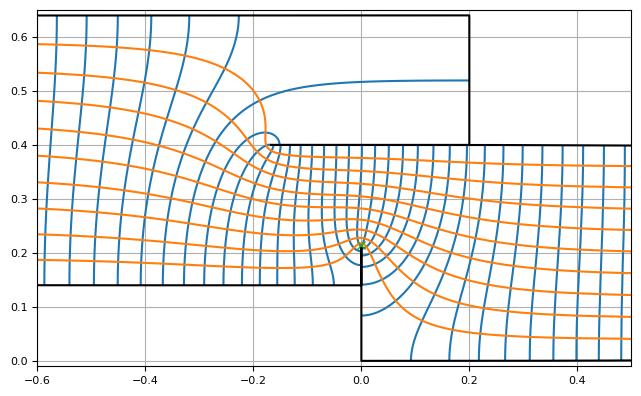

In [76]:
xi, eta = np.meshgrid(np.linspace(1e-6, L-1e-6, 600), np.linspace(1e-6, B-1e-5, 600))
zeta = xi + eta * 1j
z = funcz_arbitrary(zeta, delta1, delta2, H1, H2, L, B, N=2, linearterm=linearterm)
om = funcOmega_arbitrary(zeta, delta1, delta2, Q, L, B, N=2)
z1, z2 = compzboundary_arbitrary(L, B, H1, H2, delta1, delta2, N=2, eps=1e-3, linearterm=linearterm, eps2=1e-5)
#
plt.figure(figsize=(10, 4))
plt.subplot(aspect=1)
cs = plt.contour(z.real, z.imag, om.real, np.arange(-4, 4, 0.1), colors='C0', linestyles='-')
plt.contour(z.real, z.imag, om.imag, np.arange(0, 2, 0.1), colors='C1', linestyles='-')
plt.plot(z1.real, z1.imag, 'k')
plt.plot(z2.real, z2.imag, 'k')
#plt.axis('off')
plt.xlim(-0.6, 0.5)
plt.ylim(-0.01, 0.65)
#plt.yticks(np.arange(0, 0.9, 0.05))
#plt.plot(zp.real, zp.imag, 'C2x')
#plt.plot(zs.real, zs.imag, 'C2x')
plt.grid()
plt.tight_layout()
#plt.savefig('arbitrary_step2.eps', bbox_inches='tight')

### Relay ramp

In [29]:
linearterm = 2
delta = 0.15
H = 1
N = 5
B = 0.6
print('a: ', funcz(B * 1j, delta, A, L, B, N=N, linearterm=linearterm).imag)
xi, eta = np.meshgrid(np.linspace(1e-6, L-1e-6, 400), np.linspace(1e-6, B-1e-5, 400))
zeta = xi + eta * 1j
z = funcz(zeta, delta, H, L, B, N=N, linearterm=linearterm)
om = funcOmega(zeta, delta, Q, L, B, N=N)
z1, z2 = compzboundary(L, B, H, delta, N=N, eps=1e-4, linearterm=linearterm)

a:  1.9


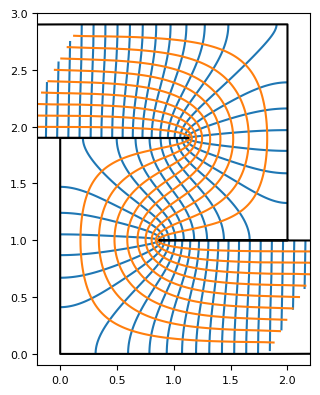

In [30]:
plt.figure(figsize=(10, 4))
plt.subplot(aspect=1)
cs = plt.contour(z.real, z.imag, om.real, np.arange(-3, 3, 0.1), colors='C0', linestyles='-')
plt.contour(z.real, z.imag, om.imag, np.arange(0, 2, 0.1), colors='C1', linestyles='-')
plt.plot(z1.real, z1.imag, 'k')
plt.plot(z2.real, z2.imag, 'k')
#plt.axis('off')
plt.xlim(-0.2, 2.2)
plt.ylim(-0.1, 3)
plt.tight_layout()
#plt.savefig('relay_ramp_flownet.eps', bbox_inches='tight')
#plt.grid()

In [31]:
def funczprealbot(ksi, delta, H, L, B, N=2, linearterm=linearterm):
    return funczp(ksi + 1e-8j, delta, H, L, B, N=2, linearterm=linearterm).real

In [39]:
ksi_p = fsolve(funczprealbot, 0.2, args=(delta, H, L, B, N, linearterm))
z_p = funcz(ksi_p + 1e-8j, delta, H, L, B, N, linearterm)
print('z_p ', z_p)
print('p: ', linearterm - z_p.real)

z_p  [0.87080793+1.j]
p:  [1.12919207]
